In [1]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook as tqdm

In [2]:
url_search = 'https://rating.chgk.info/api/tournaments.json/search?name={}'
url_tournament = 'https://rating.chgk.info/api/tournaments/{}/list'
url_recaps = 'https://rating.chgk.info/api/tournaments/{idtournament}/recaps/{idteam}'
url_player = 'https://rating.chgk.info/api/players/{}'

In [3]:
search = 'кубок европы'

In [4]:
response = requests.get(url_search.format(search)).text
response = json.load(StringIO(response))
tournaments = pd.DataFrame(response['items'])

In [5]:
tournaments.head()

,idtournament,name,date_start,date_end,type_name,archive,date_archived_at
0,2143,Кубок Европы среди студентов,2005-10-08 00:00:00,2005-10-09 00:00:00,Обычный,None,None
1,2144,Кубок Европы среди студентов,2006-11-10 00:00:00,2006-11-12 00:00:00,Обычный,None,None
2,2241,Кубок Европы среди студентов,2007-11-09 00:00:00,2007-11-11 00:00:00,Обычный,None,None
3,2240,Кубок Европы среди студентов,2008-11-07 00:00:00,2008-11-09 00:00:00,Обычный,None,None
4,1692,Кубок Европы среди студентов,2009-11-06 00:00:00,2009-11-08 00:00:00,Обычный,None,None


In [6]:
def get_player_stat_tournament(idtournament):
    tournament_results = json.load(StringIO(requests.get(url_tournament.format(idtournament)).text))
    player_results = []
    
    for team_result in tournament_results:
        position = float(team_result['position'])
        team_recaps = json.load(StringIO(requests.get(url_recaps.format(idtournament=idtournament, idteam=team_result['idteam'])).text))
        # Collect player stats
        for player in team_recaps:
            player_result = {'idplayer': player['idplayer'],
                             'idteam': team_result['idteam'],
                             'chgk': position}
            player_results.append(player_result)

    return pd.DataFrame(player_results)

In [7]:
player_results = []
for i, r in tqdm(tournaments.iterrows(), total=len(tournaments)):
    res = get_player_stat_tournament(r['idtournament'])
    res['year'] = r['date_end'].split('-')[0]
    player_results.append(res)
player_results

[    idplayer idteam  chgk  year
 0       8077     10   6.5  2005
 1      21026     10   6.5  2005
 2      23442     10   6.5  2005
 3      25516     10   6.5  2005
 4      28419     10   6.5  2005
 ..       ...    ...   ...   ...
 147     9837  42396   5.0  2005
 148    22553  42396   5.0  2005
 149    23853  42396   5.0  2005
 150    30260  42396   5.0  2005
 151    34039  42396   5.0  2005
 
 [152 rows x 4 columns],     idplayer idteam  chgk  year
 0      16329      9  22.0  2006
 1      18435      9  22.0  2006
 2      21698      9  22.0  2006
 3      25477      9  22.0  2006
 4      27240      9  22.0  2006
 ..       ...    ...   ...   ...
 167    15080  42403  23.5  2006
 168    25220  42403  23.5  2006
 169    25541  42403  23.5  2006
 170    29007  42403  23.5  2006
 171    37751  42403  23.5  2006
 
 [172 rows x 4 columns],     idplayer idteam  chgk  year
 0       9356     43  17.0  2007
 1      11636     43  17.0  2007
 2      12603     43  17.0  2007
 3      14633     43  17

In [8]:
all_players = pd.concat(player_results)
all_players.head()

,idplayer,idteam,chgk,year
0,8077,10,6.5,2005
1,21026,10,6.5,2005
2,23442,10,6.5,2005
3,25516,10,6.5,2005
4,28419,10,6.5,2005


In [9]:
all_players['year'] = all_players['year'].astype(float)
all_players['idteam'] = all_players['idteam'].astype(int)
all_players['idplayer'] = all_players['idplayer'].astype(int)

In [10]:
# убираем нестуденческую команду
all_players = all_players.drop(all_players[all_players['idteam']=='50186'].index)
# разделяем деленные места медалистов
all_players.loc[(all_players['year']==2019) & (all_players['idteam']==46916), "chgk"] = 3
all_players.loc[(all_players['year']==2011) & (all_players['idteam']==26730), "chgk"] = 3
all_players.loc[(all_players['year']==2011) & (all_players['idteam']==9), "chgk"] = 4

C:\Users\Iskandar\Miniconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Добавляем брейн

In [11]:
brain_year = [i for i in range(2005, 2021)]

In [12]:
brain_teams = [[967, 10, 2414], [4240, 967, 1933], [1933, 2414, 1177], [26958, 3645, 3641], [1703, 1454, 3645],
              [28275, 9, 6936], [38612, 27270, 5455], [27177, 6874, 42454], [27119, 42701, 40227], [37506, 38127, 27119],
              [45885, 48570, 38189], [55421, 48583, 47228], [53088, 4109, 51461], [59419, 47273, 55815], [51722, 41578, 65823],
              [55606, 41578, 56211]
              ]

In [13]:
brain_pos = [[j for j in range(1, 4)] for i in range(16)]

In [14]:
dict_brain = {'year': brain_year, 'idteam':brain_teams, 'brain':brain_pos}
df_brain = pd.DataFrame(dict_brain)
df_brain = df_brain.set_index(['year']).apply(pd.Series.explode).reset_index()

In [15]:
chgk_brain = pd.merge(all_players, df_brain,  how='outer', on = ['year', 'idteam'])
chgk_brain

,idplayer,idteam,chgk,year,brain
0,8077.0,10.0,6.5,2005.0,2
1,21026.0,10.0,6.5,2005.0,2
2,23442.0,10.0,6.5,2005.0,2
3,25516.0,10.0,6.5,2005.0,2
4,28419.0,10.0,6.5,2005.0,2
...,...,...,...,...,...
2722,222431.0,80115.0,15.0,2021.0,NaN
2723,225480.0,80115.0,15.0,2021.0,NaN
2724,NaN,55606.0,NaN,2020.0,1
2725,NaN,41578.0,NaN,2020.0,2


Добавляем ЭК

In [16]:
ek_year = [i for i in range(2005, 2021)]
ek_teams = [[466, 26958, 2414], [4240, 466, 2414], [1933, 2414, 2051], [26958, 9, 191], [26692, 26624, 1703],
           [5455, 28272, 28275], [41023, 9, 6521], [38612, 26730, 5150], [42701, 38011, 6937], [37506, 41579, 49195],
           [48570, 47228, 41350], [4109, 40195, 51554], [51461, 4109, 55866], [50516, 55517, 51554], [65823, 55517, 58596],
           [51560, 71559, 41578]
           ]
ek_pos = [[j for j in range(1, 4)] for i in range(16)]
dict_ek = {'year': ek_year, 'idteam':ek_teams, 'ek':ek_pos}
df_ek = pd.DataFrame(dict_ek)
df_ek = df_ek.set_index(['year']).apply(pd.Series.explode).reset_index()

In [17]:
chgk_brain_ek = pd.merge(chgk_brain, df_ek,  how='outer', on = ['year', 'idteam'])
chgk_brain_ek

,idplayer,idteam,chgk,year,brain,ek
0,8077.0,10.0,6.5,2005.0,2,NaN
1,21026.0,10.0,6.5,2005.0,2,NaN
2,23442.0,10.0,6.5,2005.0,2,NaN
3,25516.0,10.0,6.5,2005.0,2,NaN
4,28419.0,10.0,6.5,2005.0,2,NaN
...,...,...,...,...,...,...
2724,NaN,55606.0,NaN,2020.0,1,NaN
2725,NaN,41578.0,NaN,2020.0,2,3
2726,NaN,56211.0,NaN,2020.0,3,NaN
2727,NaN,51560.0,NaN,2020.0,NaN,1


Добавляем СИ

In [18]:
si_year = [i for i in range(2005, 2021)]
si_players = [[33146, 3159, 28968], [15727, 19541, 8697], [22896, 6530, 25794], [7008, 20001, 19541], [25794, 19541, 4121],
            [25794, 505, 13782], [31260, 13782, 21830], [25794, 21830, 42348], [31260, 28193, 21830], [505, 77785, 78791],
            [70750, 74382, 40939], [74382, 33792, 82308], [74382, 70750, 100501], [77785, 94420, 78358], [71365, 70750, 99361],
            [90663, 94420, 175267]
        ]
si_pos = [[j for j in range(1, 4)] for i in range(16)]
dict_si = {'year': si_year, 'idplayer':si_players, 'si':si_pos}
df_si = pd.DataFrame(dict_si)
df_si = df_si.set_index(['year']).apply(pd.Series.explode).reset_index()

In [19]:
all_discipl = pd.merge(chgk_brain_ek, df_si,  how='outer', on = ['year', 'idplayer'])
all_discipl

,idplayer,idteam,chgk,year,brain,ek,si
0,8077.0,10.0,6.5,2005.0,2,NaN,NaN
1,21026.0,10.0,6.5,2005.0,2,NaN,NaN
2,23442.0,10.0,6.5,2005.0,2,NaN,NaN
3,25516.0,10.0,6.5,2005.0,2,NaN,NaN
4,28419.0,10.0,6.5,2005.0,2,NaN,NaN
...,...,...,...,...,...,...,...
2727,NaN,51560.0,NaN,2020.0,NaN,1,NaN
2728,NaN,71559.0,NaN,2020.0,NaN,2,NaN
2729,90663.0,NaN,NaN,2020.0,NaN,NaN,1
2730,94420.0,NaN,NaN,2020.0,NaN,NaN,2


Подсчёт участий

In [20]:
def get_name(idplayer):
    response = json.load(StringIO(requests.get(url_player.format(idplayer)).text))[0]
    return ' '.join([response['surname'], response['name'], response['patronymic']])

def get_names(players):
    return [get_name(i) for i in tqdm(players)]

In [21]:
tournament_counts = all_discipl.groupby('idplayer').count().iloc[:,0].sort_values(ascending=False)
n_times_players_names = get_names(tournament_counts.index.tolist()[:15])
n_times_players = pd.DataFrame(tournament_counts).reset_index()
n_times_players.loc[:14, 'name'] = n_times_players_names
n_times_players.head(15)

,idplayer,idteam,name
0,32004.0,8,Топчий Иван Александрович
1,34936.0,7,Чернышёв Кирилл Александрович
2,25794.0,7,Порицкий Владислав Валерьевич
3,21560.0,7,Морозов Александр Владимирович
4,34909.0,7,Чернуха Ирина Викторовна
5,78734.0,7,Зайков Иван Анатольевич
6,63668.0,7,Серобян Эдгар Робертович
7,18194.0,6,Кленницкая Мария Владимировна
8,100501.0,6,Шевела Никита Игоревич
9,67127.0,6,Иоков Антон Сергеевич


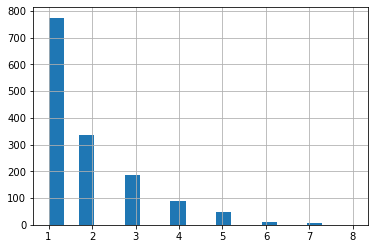

In [22]:
n_times_players['idteam'].hist(bins=20)
plt.show()

In [23]:
n_times_players['idteam'].value_counts()

1    774
2    336
3    188
4     88
5     48
6     12
7      6
8      1
Name: idteam, dtype: int64

Подсчёт медалей

In [24]:
# фильтр мест
medalists = all_discipl.loc[(all_discipl['chgk'] < 4) | (all_discipl['brain'] < 4) | (all_discipl['ek'] < 4)| (all_discipl['si'] < 4), ['idplayer', 'chgk', 'brain', 'ek', 'si']].reset_index(drop=True)
medalists.loc[medalists['chgk'] > 3, 'chgk'] = np.nan
medalists

,idplayer,chgk,brain,ek,si
0,8077.0,NaN,2,NaN,NaN
1,21026.0,NaN,2,NaN,NaN
2,23442.0,NaN,2,NaN,NaN
3,25516.0,NaN,2,NaN,NaN
4,28419.0,NaN,2,NaN,NaN
...,...,...,...,...,...
688,NaN,NaN,NaN,1,NaN
689,NaN,NaN,NaN,2,NaN
690,90663.0,NaN,NaN,NaN,1
691,94420.0,NaN,NaN,NaN,2


In [25]:
medalists_aggregated = pd.get_dummies(medalists, columns=['chgk', 'brain', 'ek', 'si']).groupby('idplayer').sum()
medalists_aggregated['chgk_sum'] = medalists_aggregated.loc[:,'chgk_1.0':'chgk_3.0'].sum(axis=1)
medalists_aggregated['brain_sum'] = medalists_aggregated.loc[:,'brain_1':'brain_3'].sum(axis=1)
medalists_aggregated['ek_sum'] = medalists_aggregated.loc[:,'ek_1':'ek_3'].sum(axis=1)
medalists_aggregated['si_sum'] = medalists_aggregated.loc[:,'si_1':'si_3'].sum(axis=1)
medalists_aggregated['sum'] = medalists_aggregated.loc[:,'chgk_sum':'si_sum'].sum(axis=1)
medalists_aggregated['name'] = get_names(medalists_aggregated.index.tolist())
cols = ['name', 'sum', 'chgk_sum', 'chgk_1.0', 'chgk_2.0', 'chgk_3.0', 'brain_sum', 'brain_1', 'brain_2', 'brain_3',  
        'ek_sum', 'ek_1', 'ek_2', 'ek_3', 'si_sum', 'si_1', 'si_2', 'si_3']
medalists_aggregated = medalists_aggregated[cols]
cols.remove('name')
medalists_aggregated = medalists_aggregated.sort_values(ascending=False, axis=0, by=cols)
medalists_aggregated = medalists_aggregated.reset_index(drop=True)
medalists_aggregated.head(50)

,name,sum,chgk_sum,chgk_1.0,chgk_2.0,chgk_3.0,brain_sum,brain_1,brain_2,brain_3,ek_sum,ek_1,ek_2,ek_3,si_sum,si_1,si_2,si_3
0,Алхазов Григорий Эдуардович,13,5,1,2,2,4,3,0,1,4,2,1,1,0,0,0,0
1,Малкин Михаил Леонидович,13,4,2,1,1,3,0,1,2,3,0,1,2,3,0,2,1
2,Новосёлов Михаил Андреевич,12,4,3,1,0,2,0,2,0,3,2,1,0,3,2,1,0
3,Порицкий Владислав Валерьевич,12,3,1,0,2,2,2,0,0,3,1,0,2,4,3,0,1
4,Галиакберов Денис Андреевич,11,4,1,3,0,2,1,1,0,2,0,1,1,3,1,2,0
5,Миронов Денис Эдуардович,11,4,0,2,2,3,1,1,1,4,1,1,2,0,0,0,0
6,Горбунов Сергей Валерьевич,9,3,0,2,1,3,2,0,1,3,2,1,0,0,0,0,0
7,Чернуха Ирина Викторовна,8,4,0,3,1,2,1,1,0,2,2,0,0,0,0,0,0
8,Печеный Александр Павлович,7,4,2,2,0,2,0,1,1,1,1,0,0,0,0,0,0
9,Топчий Иван Александрович,7,3,1,0,2,2,2,0,0,2,1,0,1,0,0,0,0


In [27]:
medalists_aggregated.to_csv('medalists_kest.csv', index=False)